# Explore vaccines data

In [73]:
import pandas as pd
import numpy as np

In [74]:
df = pd.read_csv("../hope-keyword-templates/vaccin_vis.csv")
df.head()

,index,created_at,id,text,search_keyword,neg,neu,pos,compound,date,mentioneless_text,text50,dupe50
0,0,2020-02-01 07:49:05+00:00,1.223514e+18,@RasmusThunberg @RebekkaLevysohn Det ligger vi...,['vaccin'],0.111,0.823,0.066,-0.5733,2020-02-01,"Det ligger vidst helt fast, det ender vel me...","Det ligger vidst helt fast, det ender vel me...",False
1,1,2020-02-01 08:03:44+00:00,1.223517e+18,🎙️Podcast: Malaria-parasitten har snydt alle h...,['vaccin'],0.107,0.783,0.111,-0.2237,2020-02-01,Podcast: Malaria-parasitten har snydt alle hid...,Podcast: Malaria-parasitten har snydt alle hid...,False
2,2,2020-02-01 08:10:34+00:00,1.223519e+18,Fra i dag kan endnu flere drenge blive beskytt...,['vaccin'],0.176,0.750,0.074,-0.5160,2020-02-01,Fra i dag kan endnu flere drenge blive beskytt...,Fra i dag kan endnu flere drenge blive beskytt...,False
3,3,2020-02-01 08:47:14+00:00,1.223528e+18,Se hvilke årgange af drenge som kan få HPV-vac...,['vaccin'],0.128,0.825,0.047,-0.4358,2020-02-01,Se hvilke årgange af drenge som kan få HPV-vac...,Se hvilke årgange af drenge som kan få HPV-vac...,False
4,4,2020-02-01 10:27:28+00:00,1.223553e+18,@mettelolkhanak I advokerer for vi skal vaccin...,['vaccin'],0.000,0.614,0.386,0.6875,2020-02-01,"I advokerer for vi skal vaccinere vore børn, ...","I advokerer for vi skal vaccinere vore børn, ...",False


## Tweet frequency over time

In [75]:
# Aggregate a frequency DF
def get_tweet_frequencies(df):
    # Add freq of hashtags by themselves in the dataset
    tweet_freq = pd.DataFrame({'nr_of_tweets' : df.groupby(['date']).size()}).reset_index()

    # Add the whole_frew to id_hashtag
    freq_tweets = pd.merge(df, tweet_freq, how='left', on=['date'])#, 'id', 'created_at'])
    
    return freq_tweets

In [76]:
# Create a column which is just date
df["date"] = pd.to_datetime(df["created_at"], utc=True).dt.strftime('%Y-%m-%d')

freq_df = get_tweet_frequencies(df)

In [77]:
freq_df.nr_of_tweets.describe()

count    73716.000000
mean       528.589804
std        353.526777
min          1.000000
25%        271.000000
50%        492.000000
75%        709.000000
max       1535.000000
Name: nr_of_tweets, dtype: float64

In [78]:
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyplot_themes as themes
import datetime as dt

In [79]:
freq_df["date"] = pd.to_datetime(freq_df["date"])
freq_df['date_ordinal'] = pd.to_datetime(freq_df['date']).apply(lambda date: date.toordinal())

In [80]:
# Add gaussian smoothing
def gaussian_kernel(arr, sigma=False, fwhm=False):
    """ gaussian kernel smoother for signal arr
    - sigma: standard deviation of gaussian distribution
    - fwhm: full width at half maximum of gaussian distribution
    """
    y_vals = np.array(arr)
    x_vals = np.arange(arr.shape[0])
    if sigma == fwhm:
        print("[INFO] Define parameters \u03C3 xor FWHM")
        pass
    elif fwhm:
        sigma = fwhm / np.sqrt(8 * np.log(2))
    else:
        sigma = sigma
        fwhm = sigma * np.sqrt(8 * np.log(2))
    print("[INFO] Applying Gaussian kernel for \u03C3 = {} and FWHM = {} ".format(round(sigma,2), round(fwhm,2)))
    smoothed_vals = np.zeros(y_vals.shape)
    for x_position in x_vals:
        kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
        kernel = kernel / sum(kernel)
        smoothed_vals[x_position] = sum(y_vals * kernel)
    return smoothed_vals

In [81]:
freq_df["smooth"] = gaussian_kernel(freq_df["nr_of_tweets"], sigma = 1, fwhm = 2000)

[INFO] Applying Gaussian kernel for σ = 849.32 and FWHM = 2000 


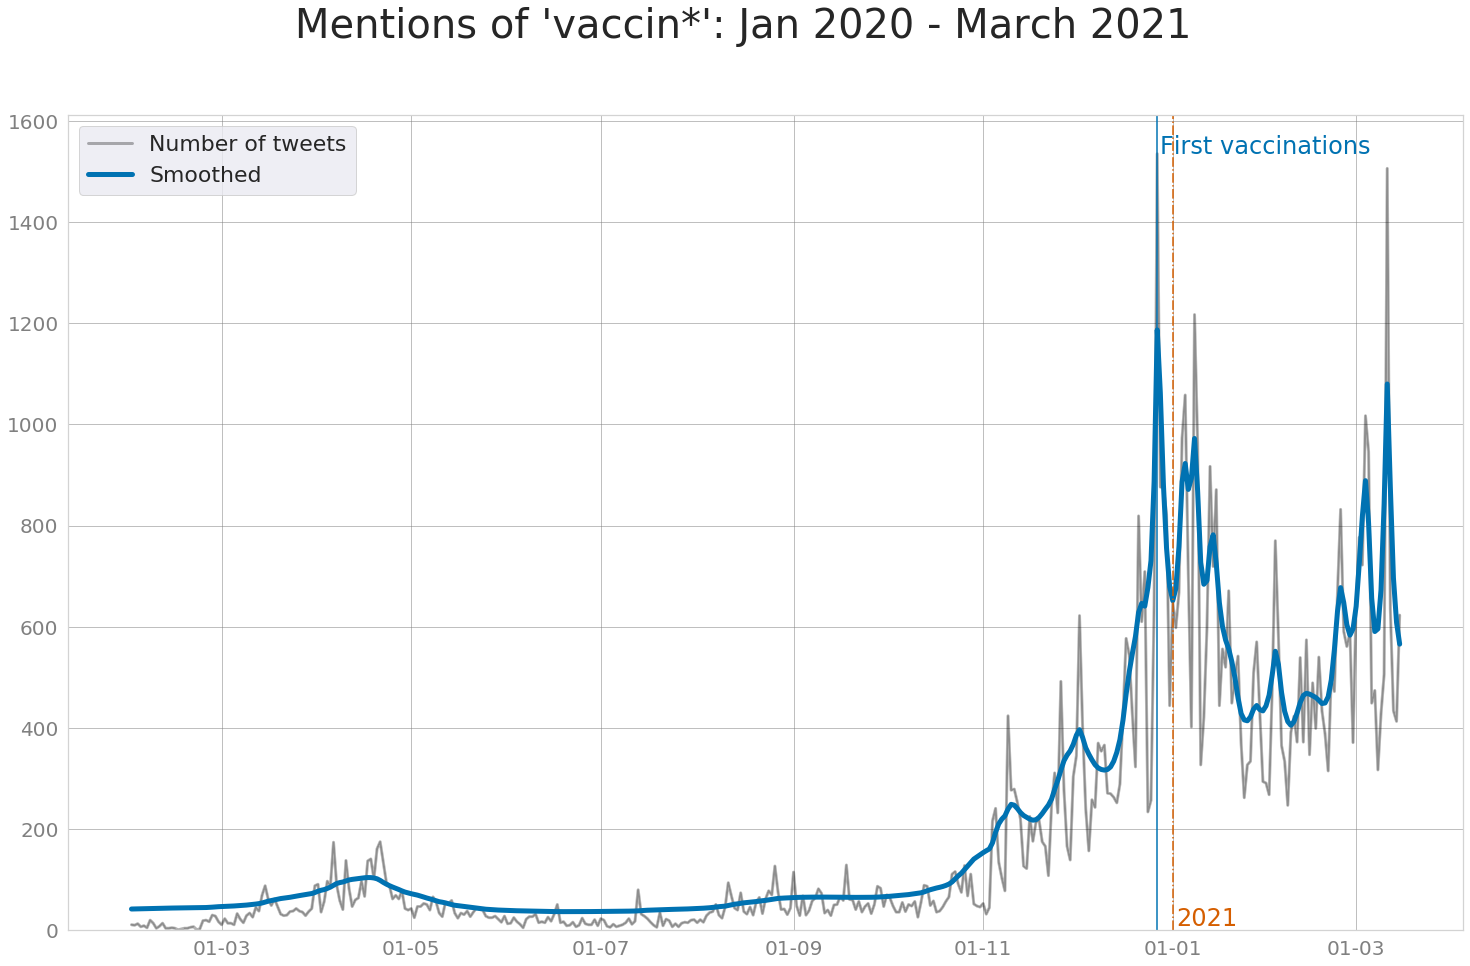

In [87]:
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

nr_colors = len(freq_df["date"].unique())

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
sns.set(font_scale = 2)
ax1 = sns.lineplot(x="date", y="nr_of_tweets", 
                  color = palette[0], 
                   alpha = 0.30,
                   label = "Number of tweets",
                     linewidth = 3, data = freq_df)

ax1 = sns.lineplot(x="date", y="smooth", 
                  color = palette[5], 
                   label = "Smoothed",
                     linewidth = 5, data = freq_df)


ax1.set(xlabel="", ylabel = "")
ax1.xaxis.get_label().set_fontsize(40)
ax1.yaxis.get_label().set_fontsize(40)

ax1.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

plt.axvline(dt.datetime(2021, 1, 1), color=palette[6], linestyle = "dashdot")
plt.text(x = dt.datetime(2021, 1, 2), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = 10,#freq_df[freq_df["date"] == "2021-01-02"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = '2021', # data label
 color = palette[6])

plt.axvline(dt.datetime(2020, 12, 27), color=palette[5])
plt.text(x = dt.datetime(2020, 12, 28), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = freq_df[freq_df["date"] == "2020-12-27"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = 'First vaccinations', # data label
 color = palette[5])

# Define the date format
ax1.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

ax1.set(ylim=(0, None))
fig.suptitle("Mentions of 'vaccin*': Jan 2020 - March 2021", size = "40")
#ax1.set_title('Level 1', fontsize=30)

#ax1.legend_.remove()

plot_name = "fig/all_vaccin_mentions.png"
fig.savefig(plot_name)

fig.show()

In [83]:
# Now from 1.11 - March
freq_df["date"] = pd.to_datetime(df["date"])#, utc=True).dt.strftime('%Y-%m-%d')
mask = (freq_df['date'] > '2020-10-30') & (freq_df['date'] <= '2021-04-01')
wfreq_df = freq_df.loc[mask]

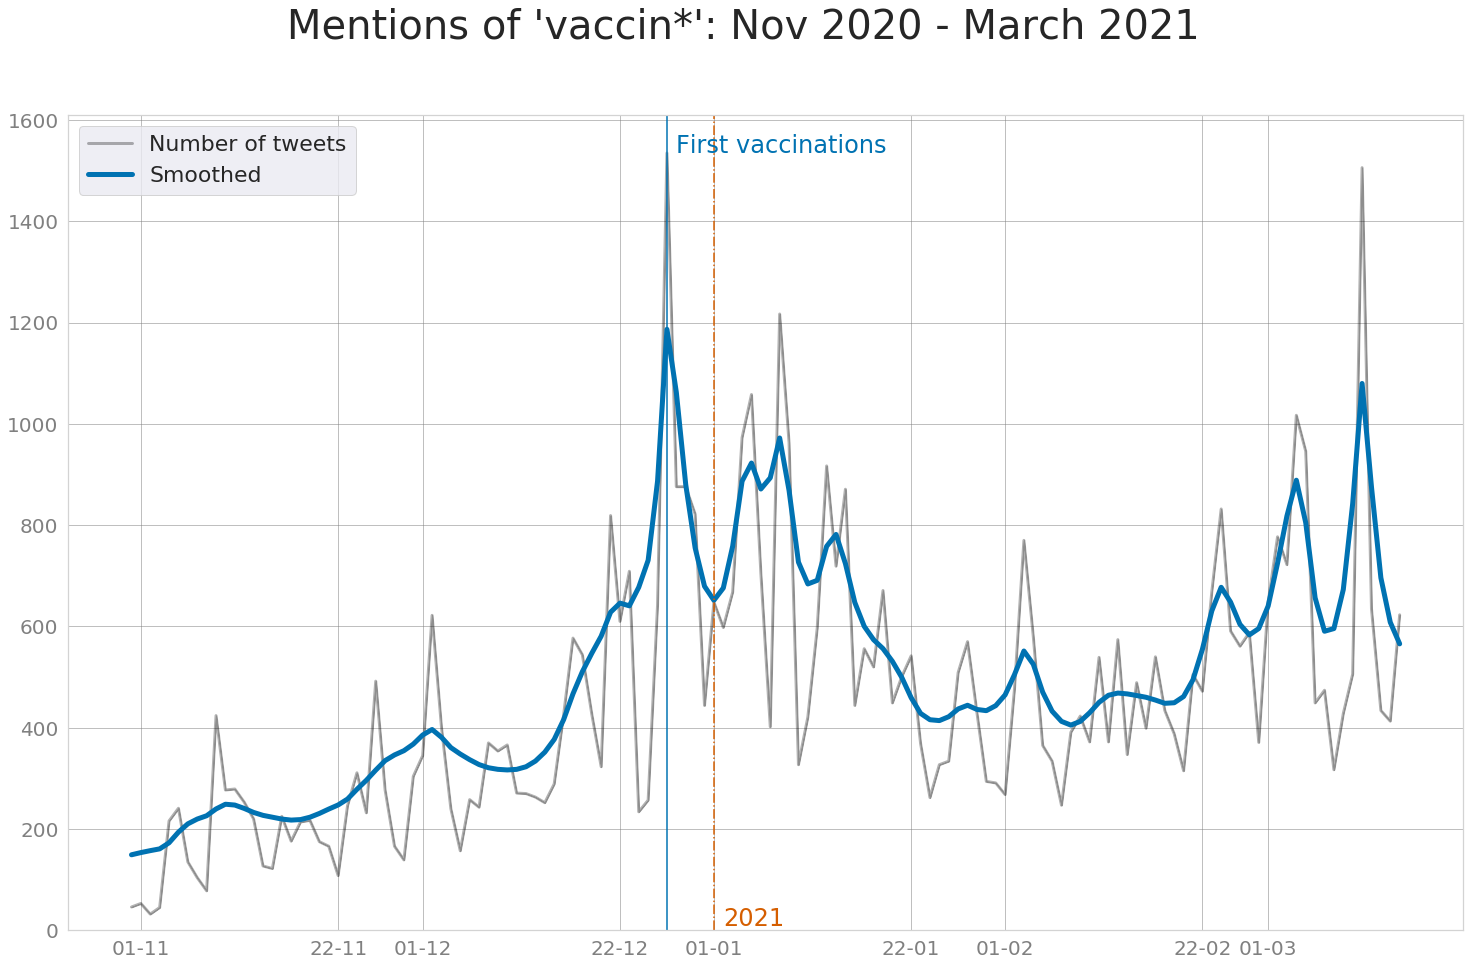

In [86]:
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

nr_colors = len(freq_df["date"].unique())

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
sns.set(font_scale = 2)


ax1 = sns.lineplot(x="date", y="nr_of_tweets", 
                  color = palette[0], 
                   alpha = 0.30,
                   label = "Number of tweets",
                     linewidth = 3, data = wfreq_df)

ax1 = sns.lineplot(x="date", y="smooth", 
                  color = palette[5], 
                   label = "Smoothed",
                     linewidth = 5, data = wfreq_df)


ax1.set(xlabel="", ylabel = "")
ax1.xaxis.get_label().set_fontsize(40)
ax1.yaxis.get_label().set_fontsize(40)

ax1.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

plt.axvline(dt.datetime(2021, 1, 1), color=palette[6], linestyle = "dashdot")
plt.text(x = dt.datetime(2021, 1, 2), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = 10,#freq_df[freq_df["date"] == "2021-01-02"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = '2021', # data label
 color = palette[6])

plt.axvline(dt.datetime(2020, 12, 27), color=palette[5])
plt.text(x = dt.datetime(2020, 12, 28), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = freq_df[freq_df["date"] == "2020-12-27"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = 'First vaccinations', # data label
 color = palette[5])

#plt.axvline(dt.datetime(2020, 12, 21), color=palette[5])
#plt.text(x = dt.datetime(2020, 12, 22), # x-coordinate position of data label, adjusted to be 3 right of the data point
# y = freq_df[freq_df["date"] == "2020-12-21"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
# s = 'Discussion starts about new "epidemilov"', # data label
# color = palette[5])

#plt.axvline(dt.datetime(2021, 1, 18), color=palette[5])
#plt.text(x = dt.datetime(2021, 1, 19), # x-coordinate position of data label, adjusted to be 3 right of the data point
# y = freq_df[freq_df["date"] == "2021-01-18"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
# s = 'Vaccine supply delays delay vaccination', # data label
# color = palette[5])

#plt.axvline(dt.datetime(2021, 1, 13), color=palette[5])
#plt.text(x = dt.datetime(2021, 1, 14), # x-coordinate position of data label, adjusted to be 3 right of the data point
# y = freq_df[freq_df["date"] == "2021-01-13"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
# s = 'Lockdown extended', # data label
# color = palette[5])

# Define the date format
ax1.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

ax1.set(ylim=(0, None))
fig.suptitle("Mentions of 'vaccin*': Nov 2020 - March 2021", size = "40")
#ax1.set_title('Level 1', fontsize=30)

#ax1.legend_.remove()

plot_name = "fig/all_vaccin_mentions_winter.png"
fig.savefig(plot_name)

fig.show()

# Hashtags

In [103]:
import re

def extract_hashtags(row):
    unique_hashtag_list = list(re.findall(r'#\S*\w', row["text"]))
    return unique_hashtag_list

def hashtag_per_row(data):
    # Create hashtags column with the actual unique hashtags
    data["hashtags"] = data.apply(lambda row: extract_hashtags(row), axis = 1)

    # Let's take a subset of necessary columns, add id
    df = data[["date", "hashtags"]].reset_index().rename(columns={"index": "id"})

    # Select only the ones where we have more than 1 hashtag per tweet
    df = df[df["hashtags"].map(len) > 1].reset_index(drop=True)

    # Hashtag per row
    # convert list of pd.Series then stack it
    df = (df
     .set_index(['date','id'])['hashtags']
     .apply(pd.Series)
     .stack()
     .reset_index()
     .drop('level_2', axis=1)
     .rename(columns={0:'hashtag'}))
    #lowercase!
    df["hashtag"] = df["hashtag"].str.lower()
    df["hashtag"] = df["hashtag"].str.replace("'.", "")
    df["hashtag"] = df["hashtag"].str.replace("’.", "")

    return df

#freq_df["hashtags"] = freq_df.apply(lambda row: extract_b117(row), axis = 1)

hashtags = hashtag_per_row(wfreq_df)

/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [104]:
# Aggregate a frequency DF
def get_hashtag_frequencies(df):
    # Add freq of hashtags by themselves in the dataset
    tweet_freq = pd.DataFrame({'nr_of_hashtags' : df.groupby(['hashtag']).size()}).reset_index()

    # Add the whole_frew to id_hashtag
    #freq_hashtags = pd.merge(df, tweet_freq, how='left', on=['date'])#, 'id', 'created_at'])
    
    #df0 = freq_hashtags
    return tweet_freq

In [105]:
freq_hashtags = get_hashtag_frequencies(hashtags)
df1 = freq_hashtags.sort_values(by=['nr_of_hashtags'], ascending=False)

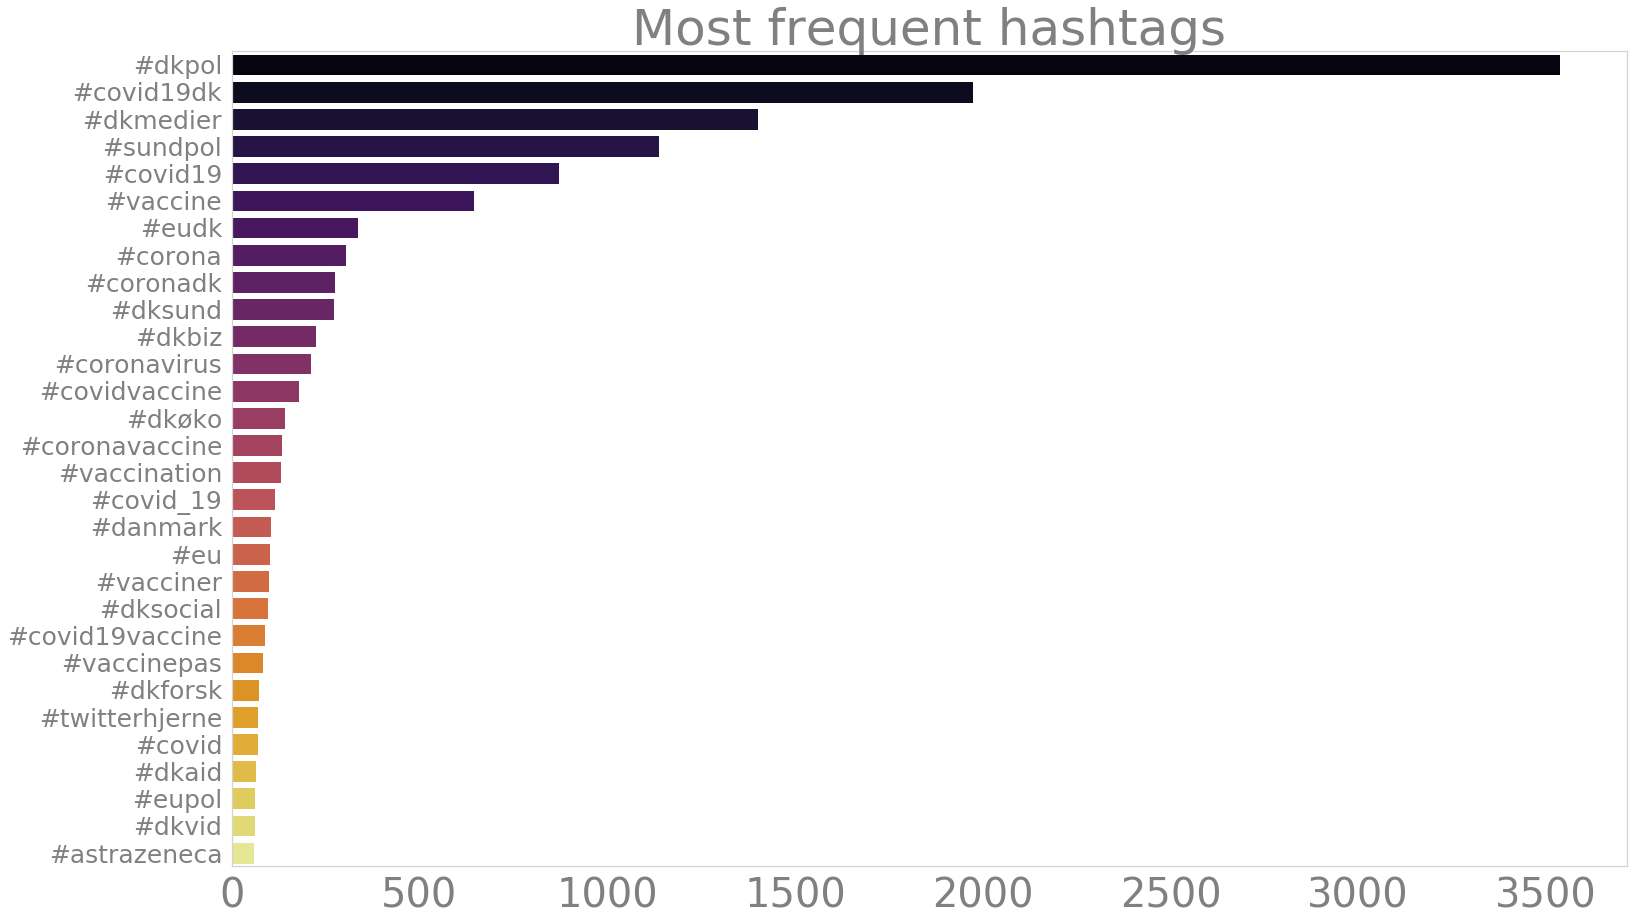

In [106]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

df0 = df1.nlargest(30, columns=['nr_of_hashtags'])
nr_hash = len(df0["hashtag"].unique())
themes.theme_minimal(grid=False, ticks=False, fontsize=40)

a4_dims = (25,15) #(11.7, 8.27)
fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

palette = sns.color_palette("inferno", nr_hash)

ax = sns.barplot(y="hashtag", x="nr_of_hashtags", palette = palette, data = df0)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent hashtags",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

ax.grid(color='white', linestyle='-', linewidth=0.5, which= "both")

plot_name = "fig/frequent_hashtags.png"
fig.savefig(plot_name)

In [107]:
per_date = hashtags[['date', 'id', 'hashtag']].groupby(['date', 'hashtag']).agg(['count']).reset_index()
per_date["hashtag_per_date"] = per_date["id"]["count"]
per_date = per_date[["date", "hashtag", "hashtag_per_date"]]
per_date = per_date.rename(columns={"hashtag": "Hashtag"})

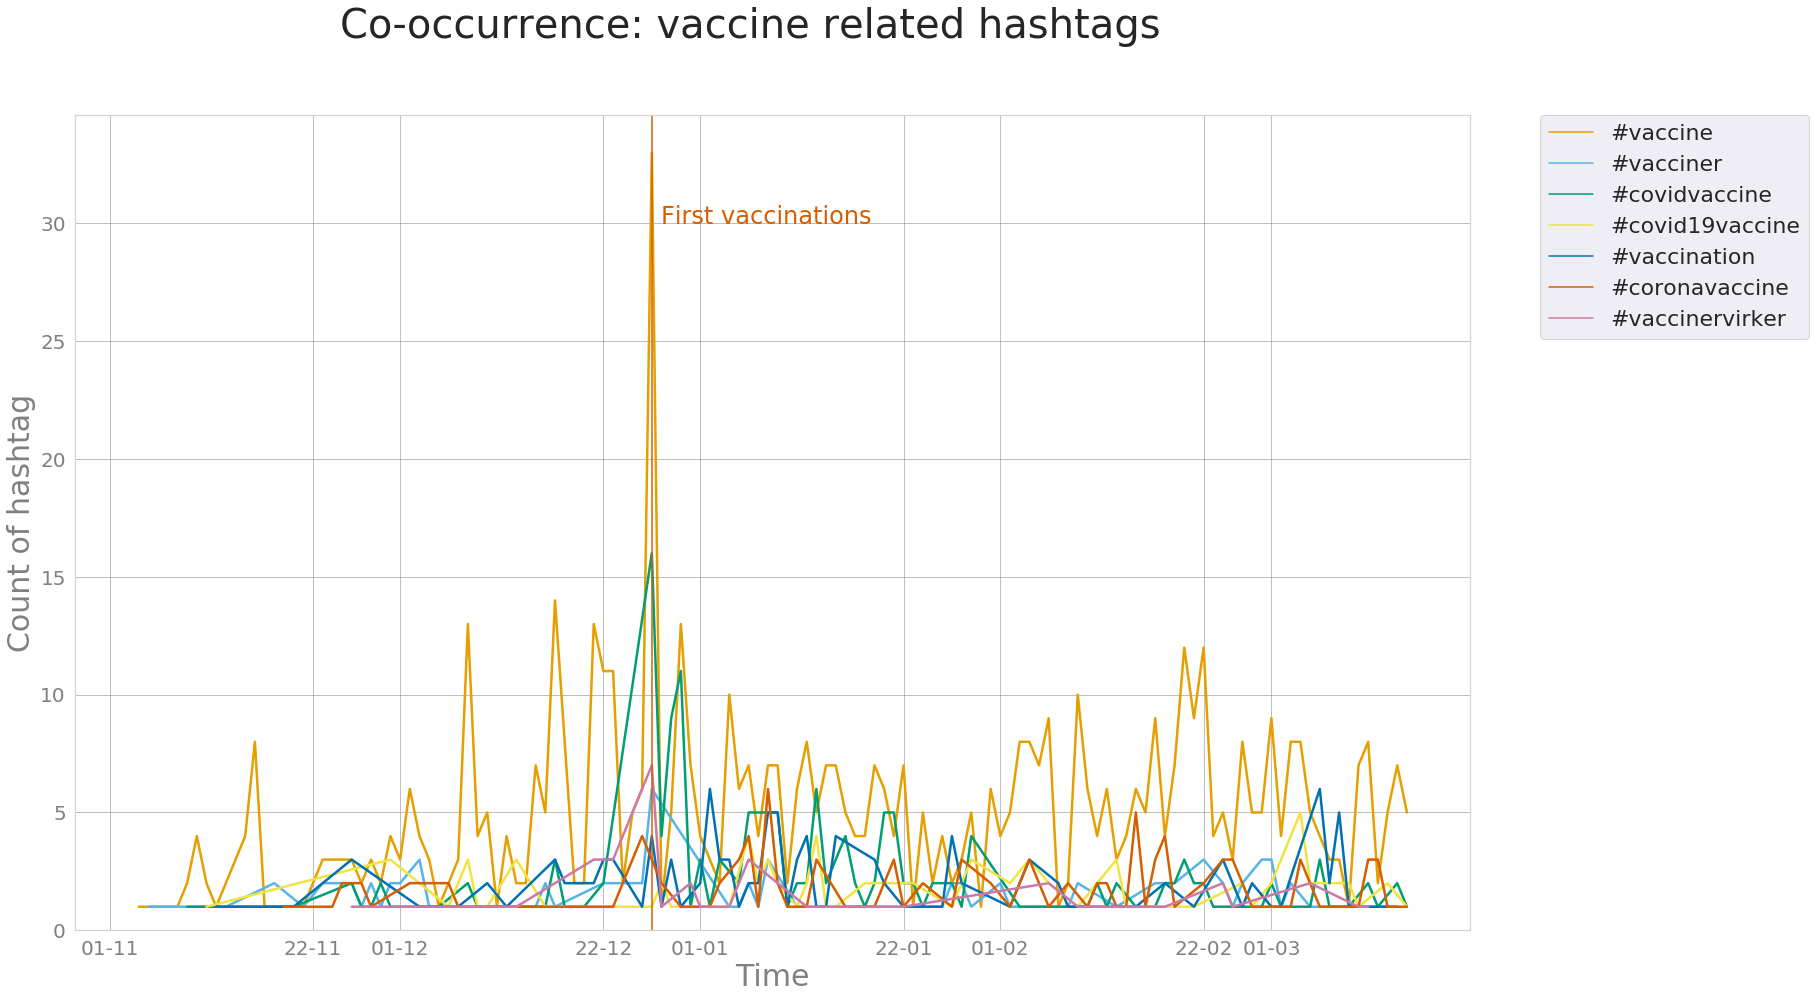

In [108]:
df0 = per_date.loc[per_date['Hashtag'].isin(['#vaccine', "#covidvaccine", "#vaccination", "#coronavaccine", "#vacciner", "#covid19vaccine", "#vaccinervirker"])].reset_index(drop=False)
nr_hash = len(df0["Hashtag"].unique())

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

#palette = sns.color_palette("inferno", nr_hash)
palette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]


fig, ax = plt.subplots(figsize=a4_dims)
sns.set(font_scale = 2)

ax = sns.lineplot(x="date", y="hashtag_per_date", 
                  hue="Hashtag", style="Hashtag", 
                  #markers = True, markersize = 10, 
                  dashes = False, 
                  palette = palette, 
                  linewidth = 2.5, data = df0)

ax.set(xlabel="Time", ylabel = "Count of hashtag")
ax.xaxis.get_label().set_fontsize(30)
ax.yaxis.get_label().set_fontsize(30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

plt.axvline(dt.datetime(2020, 12, 27), color=palette[5])
plt.text(x = dt.datetime(2020, 12, 28), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = 30, #df0[df0["date"] == "2020-12-27"]["hashtag_per_date"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = 'First vaccinations', # data label
 color = palette[5])

#plt.ylim(0, 80)

# Define the date format
ax.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)

ax.set(ylim=(0, None))
fig.suptitle('Co-occurrence: vaccine related hashtags', fontsize=40)
#ax1.set_title('Level 1', fontsize=30)

#ax1.legend_.remove()

plot_name = "fig/vaccine_hashtags_over_time.png"
fig.savefig(plot_name, bbox_extra_artists=(lgd,), bbox_inches='tight')

fig.show()

# Sentiment Analysis

In [92]:
df["date"] = pd.to_datetime(df["date"])
# Rolling average
df['compound_7day_ave'] = df.compound.rolling(7).mean().shift(-3)
df['compound_30day_ave'] = df.compound.rolling(30).mean().shift(-3)

In [94]:
df["smooth_compound"] = gaussian_kernel(df["compound"], sigma = 1, fwhm = 2000)

[INFO] Applying Gaussian kernel for σ = 849.32 and FWHM = 2000 


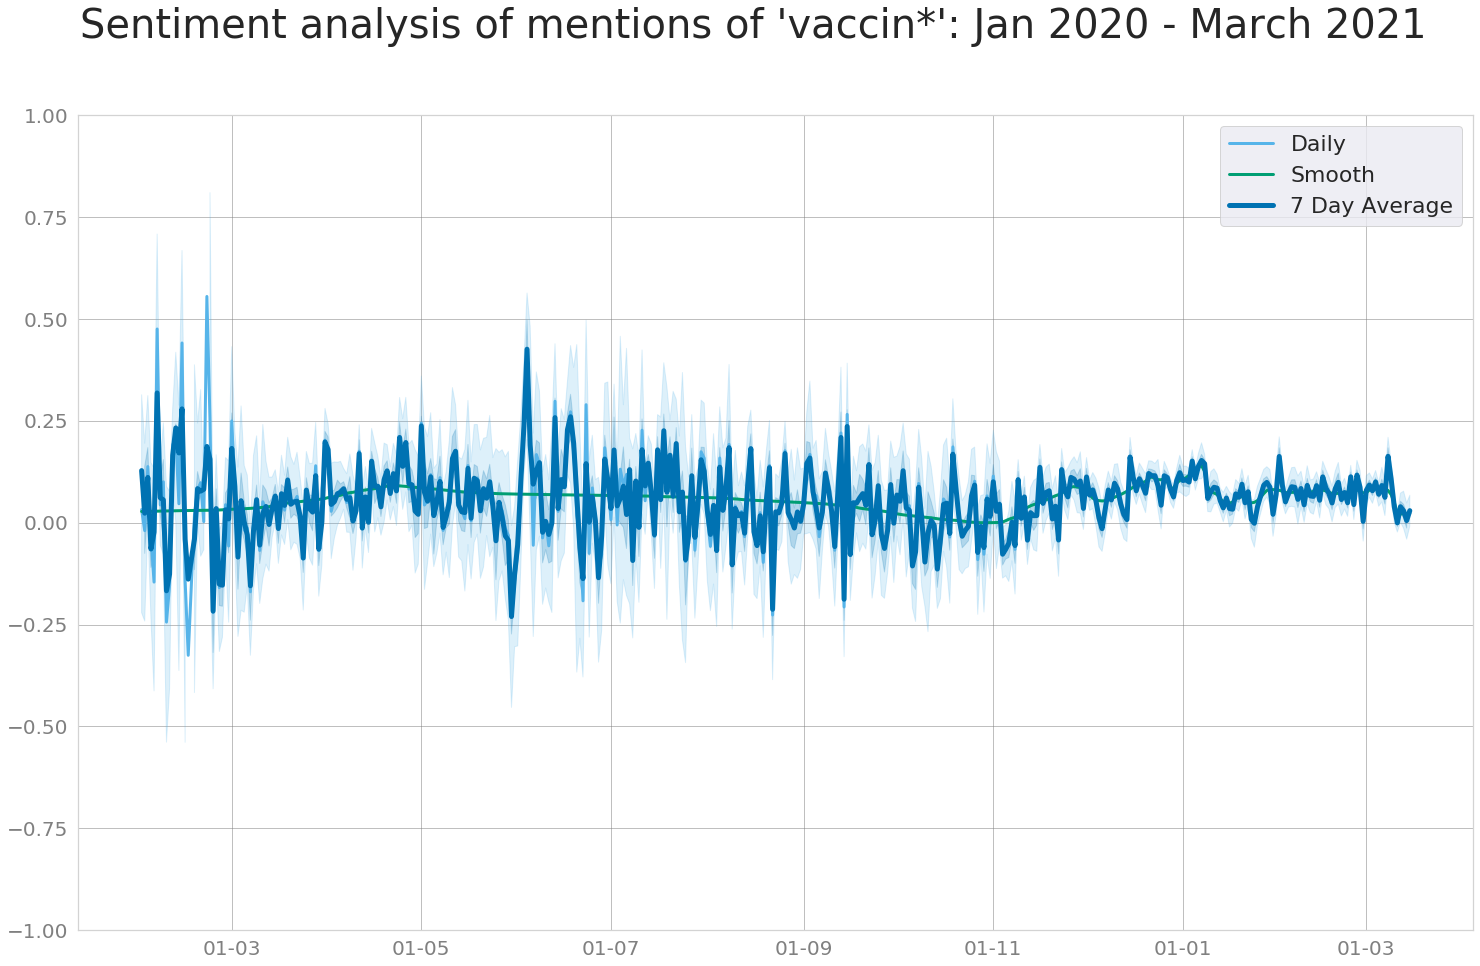

In [95]:
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)


themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
sns.set(font_scale = 2)
ax1 = sns.lineplot(x="date", y="compound", 
                   label="Daily", color = palette[2],
                     linewidth = 3, data = df)

ax1 = sns.lineplot(x="date", y="smooth_compound", 
                   label="Smooth", color = palette[3],
                     linewidth = 3, data = df)

ax1 = sns.lineplot(x="date", y="compound_7day_ave", 
                   label="7 Day Average", color = palette[5],
                     linewidth = 5, data = df)


ax1.set(xlabel="", ylabel = "")
ax1.xaxis.get_label().set_fontsize(40)
ax1.yaxis.get_label().set_fontsize(40)

ax1.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

# Define the date format
ax1.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

    
fig.suptitle("Sentiment analysis of mentions of 'vaccin*': Jan 2020 - March 2021", size = "40")
#ax1.set_title('Level 1', fontsize=30)

#ax1.legend_.remove()
ax1.set(ylim=(-1, 1))

plot_name = "fig/sentiment_compound.png"
fig.savefig(plot_name)

fig.show()

In [49]:
# Now from 1.11 - March
mask = (df['date'] > '2021-01-01') & (df['date'] <= '2021-04-01')
winter_df = df.loc[mask]

/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


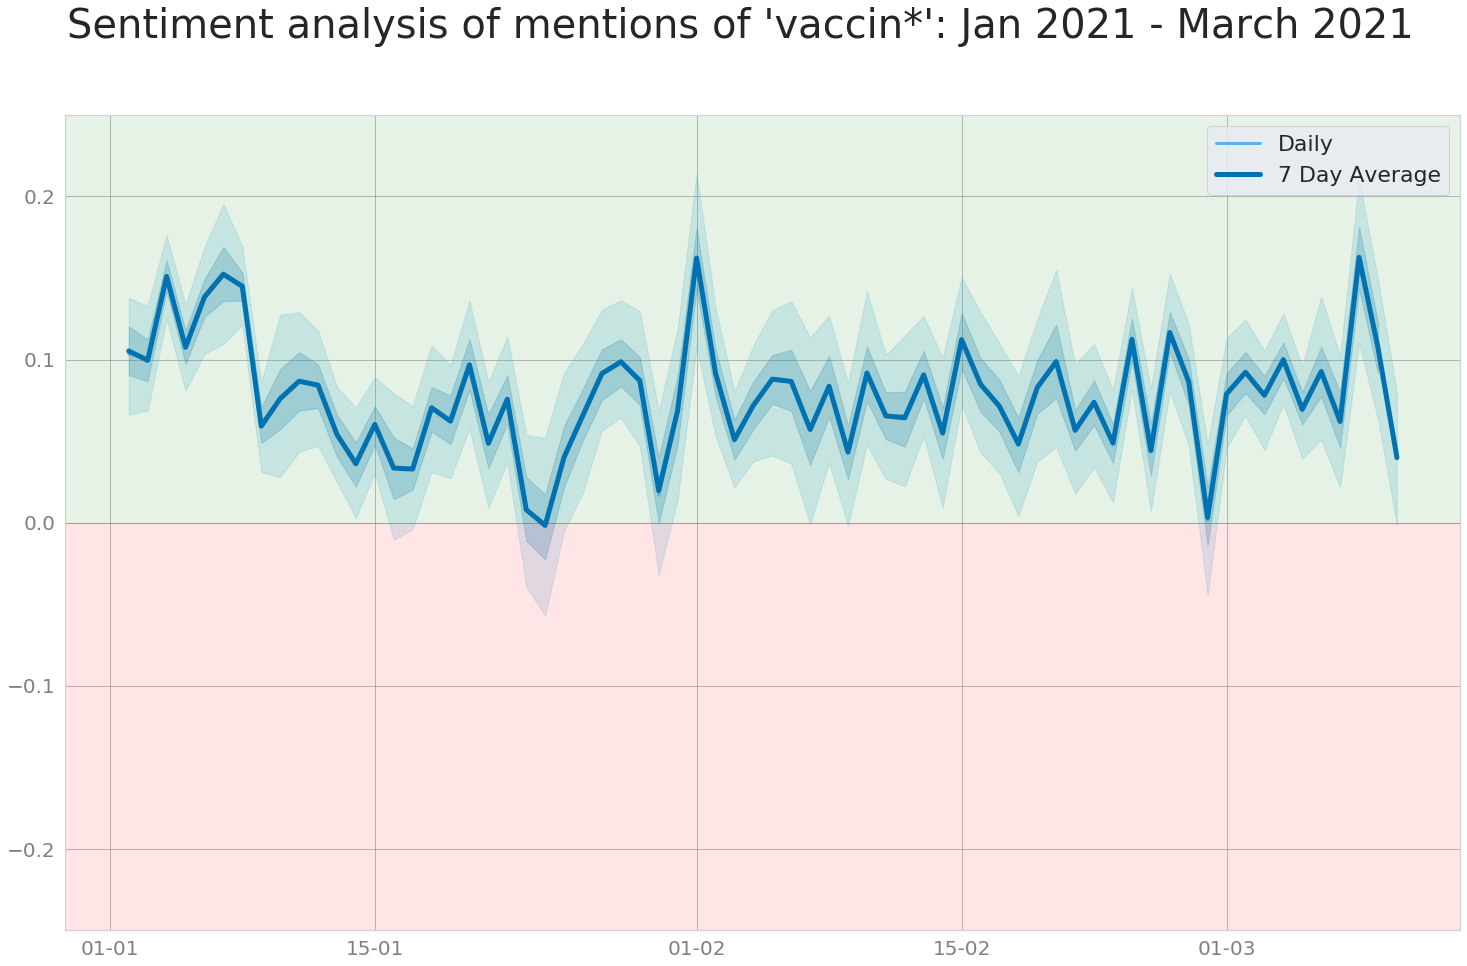

In [62]:
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)


themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
sns.set(font_scale = 2)
ax1 = sns.lineplot(x="date", y="compound", 
                   label="Daily", color = palette[2],
                     linewidth = 3, data = winter_df)

ax1 = sns.lineplot(x="date", y="compound_7day_ave", 
                   label="7 Day Average", color = palette[5],
                     linewidth = 5, data = winter_df)

#ax1 = sns.lineplot(x="date", y="compound_30day_ave", 
#                   label="30 Day Average", color = palette[7],
#                     linewidth = 5, data = df)
#plt.axvline(dt.datetime(2020, 12, 21), color=palette[5])
#plt.text(x = dt.datetime(2020, 12, 22), # x-coordinate position of data label, adjusted to be 3 right of the data point
# y = 0.75,#clean_df[clean_df["date"] == "2020-12-21"]["compound_7day_ave"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
# s = 'Flight ban from UK', # data label
# color = palette[5])

#plt.axvline(dt.datetime(2020, 12, 23), color=palette[5])
#plt.text(x = dt.datetime(2020, 12, 24), # x-coordinate position of data label, adjusted to be 3 right of the data point
# y = 0.50,#clean_df[clean_df["date"] == "2020-12-23"]["compound_7day_ave"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
# s = 'Flight ban from UK extended', # data label
# color = palette[5])

#plt.axvline(dt.datetime(2021, 1, 5), color=palette[5])
#plt.text(x = dt.datetime(2021, 1, 6), # x-coordinate position of data label, adjusted to be 3 right of the data point
# y = -0.25,#clean_df[clean_df["date"] == "2021-01-05"]["compound_7day_ave"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
# s = 'High alert, new 5m distance rules', # data label
# color = palette[5])

#plt.axvline(dt.datetime(2021, 1, 13), color=palette[5])
#plt.text(x = dt.datetime(2021, 1, 14), # x-coordinate position of data label, adjusted to be 3 right of the data point
# y = 0,#clean_df[clean_df["date"] == "2021-01-13"]["compound_7day_ave"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
# s = 'Lockdown extended', # data label
# color = palette[5])

ax1.set(xlabel="", ylabel = "")
ax1.xaxis.get_label().set_fontsize(40)
ax1.yaxis.get_label().set_fontsize(40)

ax1.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

# Define the date format
ax1.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

# Color the bg
plt.axhspan(0, 0.25, color = "green", facecolor='0.2', alpha=0.1)
plt.axhspan(0, -0.25, color = "red", facecolor='0.2', alpha=0.1)


fig.suptitle("Sentiment analysis of mentions of 'vaccin*': Jan 2021 - March 2021", size = "40")
#ax1.set_title('Level 1', fontsize=30)

#ax1.legend_.remove()
ax1.set(ylim=(-0.25, 0.25))

plot_name = "fig/sentiment_compound_winter.png"
fig.savefig(plot_name)

fig.show()

In [45]:
import spacy
import string
from string import digits
sp = spacy.load('da_core_news_lg')

file = open("../hope-keyword-templates/src/stop_words.txt","r+")
stop_words = file.read().split()

# Lemmatize stop words
stops = " ".join(stop_words)
stops = sp(stops)
my_stop_words = [t.lemma_ for t in stops]

In [46]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def lemmas(row):
    tweet = row["mentioneless_text"].lower()
    tweet = remove_emoji(tweet)
    tweet = re.sub(r'@(\S*)\w', '', tweet) #mentions
    tweet = re.sub(r'#\S*\w', '', tweet) # hashtags
    # Remove URLs
    url_pattern = re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
    tweet = re.sub(url_pattern, '', tweet)
    
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    #tweet = tweet.translate(str.maketrans('', '', digits))
    tweet = tweet.replace('”', '')
    tweet = tweet.replace('“', '')
    
    sentence = sp(tweet)
    lemmas = []
    for word in sentence:
        lemmas.append(word.lemma_)
    res = [x for x in lemmas if x not in my_stop_words]
    hmm = ['   ','  ',' ','','♂','','❤','','🤷']
    res = [x for x in res if x not in hmm]
    return res

freq_df["tokens_list"] = freq_df.apply(lambda row: lemmas(row), axis = 1)

In [47]:
def join_tokens(row):
    res = " ".join(row["tokens_list"])
    return res

freq_df["tokens_string"] = freq_df.apply(lambda row: join_tokens(row), axis = 1)
texts = freq_df["tokens_string"]

In [48]:
word_freq = freq_df.tokens_string.str.split(expand=True).stack().value_counts()

In [49]:
word_freq = word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

In [50]:
import string

texts = ", ".join(texts)
texts = texts.translate(str.maketrans('', '', string.punctuation))
texts = texts.lower()

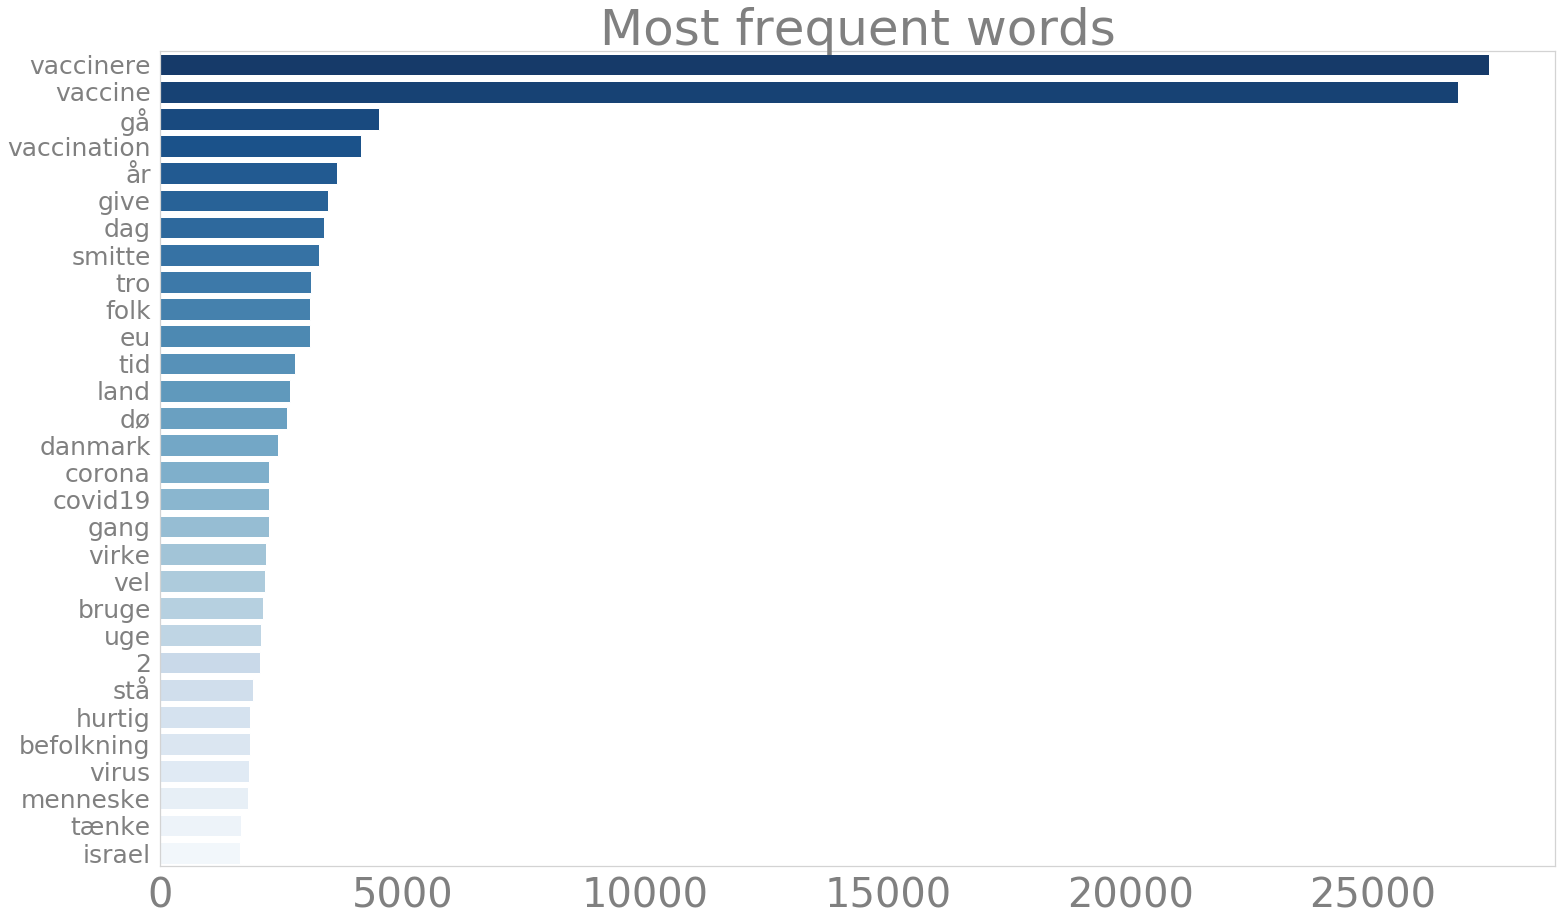

In [51]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

word_freq = word_freq[~word_freq["word"].isin(stop_words)]
df0 = word_freq.nlargest(30, columns=['Frequency'])
nr_hash = len(df0["word"].unique())

matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
palette = sns.color_palette("Blues_r", nr_hash)

ax = sns.barplot(y="word", x="Frequency", palette = palette, data = df0)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = "fig/word_frequency.png"
fig.savefig(plot_name)

In [52]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    plot_name = "fig/word_cloud.png"
    plt.savefig(plot_name)

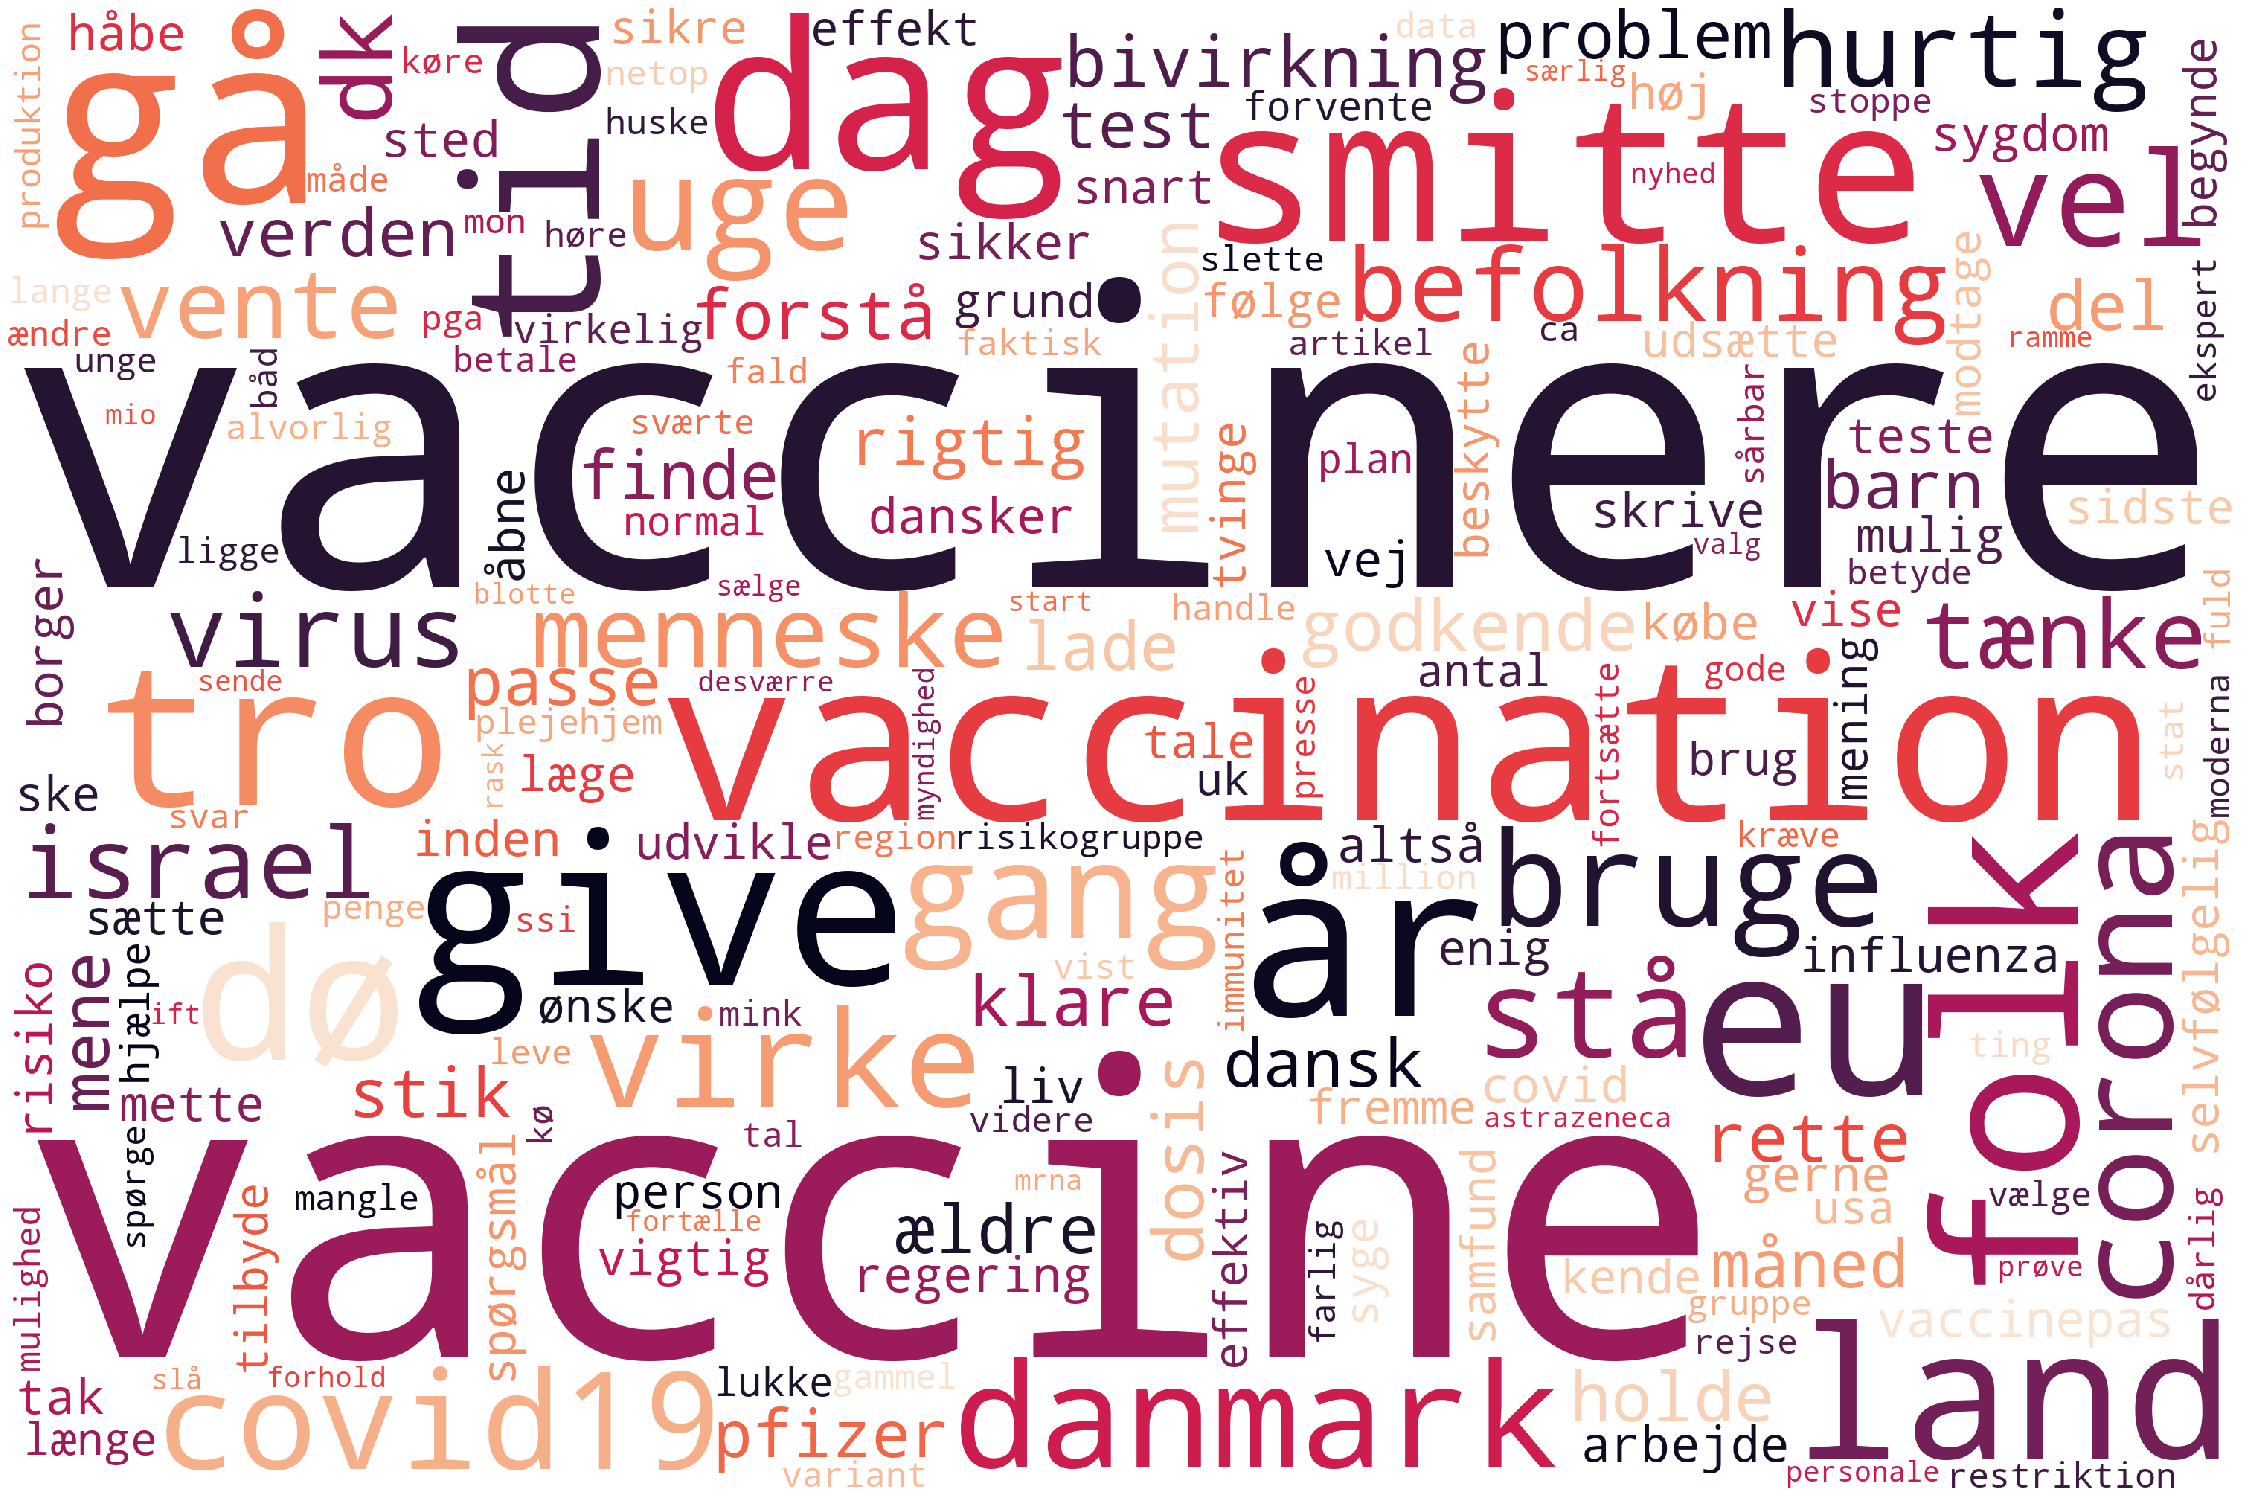

In [53]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='white', colormap="rocket", 
                      collocations=False, stopwords = stop_words).generate(texts)
# Plot
plot_cloud(wordcloud)

In [54]:
from nltk import bigrams
import itertools
import collections
import networkx as nx
import spacy
import nltk

In [55]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

#nlp = spacy.load("da_core_news_sm")

%matplotlib inline

In [56]:
freq_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58570 entries, 11535 to 70104
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              58570 non-null  int64         
 1   created_at         58570 non-null  object        
 2   id                 58570 non-null  float64       
 3   text               58570 non-null  object        
 4   search_keyword     58570 non-null  object        
 5   neg                58570 non-null  float64       
 6   neu                58570 non-null  float64       
 7   pos                58570 non-null  float64       
 8   compound           58570 non-null  float64       
 9   date               58570 non-null  datetime64[ns]
 10  mentioneless_text  58570 non-null  object        
 11  text50             58570 non-null  object        
 12  dupe50             58570 non-null  bool          
 13  nr_of_tweets       58570 non-null  int64         
 14  da

In [57]:
# Create list of lists containing bigrams in tweets
#terms_bigram = list(bigrams(wordlist))
terms_bigram = [list(bigrams(tweet)) for tweet in freq_df['tokens_list']]
#terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
terms_bigram[0]

[('sats', 'strategisk'),
 ('strategisk', 'tænkning'),
 ('tænkning', 'udfald'),
 ('udfald', 'dårlig'),
 ('dårlig', 'strategi'),
 ('strategi', 'regering'),
 ('regering', 'systematisk'),
 ('systematisk', 'fremlægge'),
 ('fremlægge', 'forventning'),
 ('forventning', 'vaccine'),
 ('vaccine', 'forventning'),
 ('forventning', 'betydning'),
 ('betydning', 'regering'),
 ('regering', 'strategi')]

In [58]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

In [59]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])

bigram_df

,bigram,count
0,"(vaccine, virke)",698
1,"(lade, vaccinere)",536
2,"(give, mening)",479
3,"(covid19, vaccine)",427
4,"(mette, frederiksen)",359
5,"(’, s)",304
6,"(lange, tid)",304
7,"(tilbyde, vaccine)",298
8,"(vaccine, passe)",289
9,"(vaccine, give)",284


In [60]:
bigram_df = bigram_df.drop([5, 27, 28, 29]).reset_index(drop=True)

In [61]:
bigram_df.head(10)

,bigram,count
0,"(vaccine, virke)",698
1,"(lade, vaccinere)",536
2,"(give, mening)",479
3,"(covid19, vaccine)",427
4,"(mette, frederiksen)",359
5,"(lange, tid)",304
6,"(tilbyde, vaccine)",298
7,"(vaccine, passe)",289
8,"(vaccine, give)",284
9,"(vaccine, godkende)",283


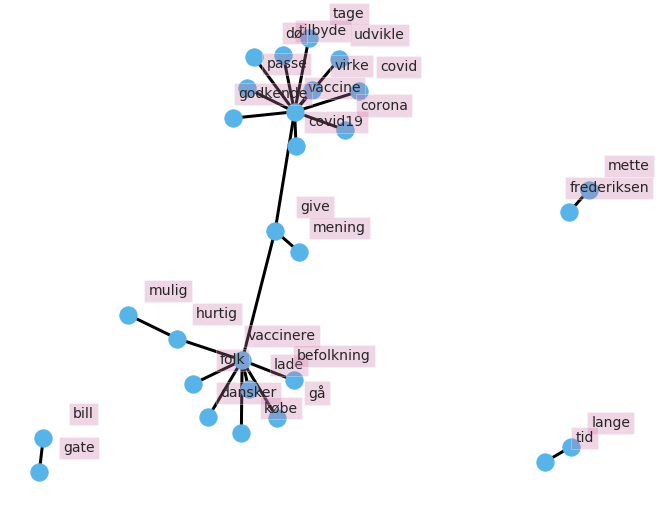

In [62]:
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Create dictionary of bigrams and their counts
d = bigram_df.set_index("bigram").T.to_dict("records")
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=3)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color= palette[0], #'red',
                 node_color= palette[2], #'green',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor= palette[7], #'red', 
                      alpha=0.3), ## 0.5),
            horizontalalignment='center', fontsize=14)
    

fig.patch.set_visible(False)
ax.axis('off')

plt.savefig("fig/bigram_graph.png", dpi=150)

plt.show()

## Ngrams with emojis? :) 

In [66]:
def extract_emoji(string):
    string = string["text"]
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    res = re.findall(emoji_pattern, string)
    #res = " ".join(res)
    return res

In [67]:
freq_df["emojis_list"] = freq_df.apply(lambda row: extract_emoji(row), axis = 1)

In [68]:
freq_df.iloc[11535].emojis_list

[]

In [69]:
emojis = freq_df[freq_df["emojis_list"] != []]

ValueError: ('Lengths must match to compare', (44786,), (0,))

In [65]:
# Create list of lists containing bigrams in tweets
#terms_bigram = list(bigrams(wordlist))
terms_bigram = [list(bigrams(tweet)) for tweet in freq_df['emojis_list']]
#terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
terms_bigram[0]

NameError: name 'bigrams' is not defined